# Multiarm bandits
Date: **2 March 2021**

Name: ***Alex GMTR***


**Overview of this notebook**

This code implements several bandit algorithms in Python. The algorithms are implemented from scratch, e.g. without reliance on any of the AutoDiff packages.
The algorithms are then tested in four experiments, with the relative performance of algorithms is visualised.

## Setup

This section sets up the bandit classes and various helper functions.

In [ ]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [ ]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [ ]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [ ]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#009988', '#0033ff', '#993388', '#ee6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=50,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# Agent implementations

## Random agent

In [ ]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## UCB agent


In [ ]:
class UCB(object):

  '''
  Notation:
  Q - array of action values at a particular time t
  N - array of number of times each arm had been pulled by the time period t
  U - upper confidence
  '''

  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.name = name
    self.c = bonus_multiplier
    self.reset()

  def step(self, previous_action, reward):

    if previous_action is not None:
      #record the fact that action 'previous_action' was taken
      self._N[previous_action] += 1
      #update the cumulative average reward
        #Calcualte a helper for the numerator
      numer_helper = reward - self._Q[previous_action]
        #Update the average in a recursive way
      self._Q[previous_action] +=  numer_helper/self._N[previous_action]
    
    #calculate the upper confidence:
    t = np.log(np.sum(self._N)) #total number of trials
    U = self.c * np.sqrt(t) / (2 * self._N)
    #calculate the objective f-n, i.e. UCB for each arm/action
    Obj_fn = self._Q + np.nan_to_num(U) # note (1)
    
    #identify the optimal action(s)
    best_actions = np.where(Obj_fn == np.max(Obj_fn))[0]
    #choose the single opimal action randomly in case of ties
    return np.random.choice(best_actions)

    #(1) nan_to_num replaces the upper bound with a very large number in cases 
    #where the arm hadn't been pulled yet


  def reset(self):
    #initialise the action values for each arm/course of action
    self._Q = np.zeros(self._number_of_arms)
    #initialise the counter for the number of pulls for each arm/action taken
    self._N = np.zeros(self._number_of_arms)

    

## $\epsilon$-greedy agent

The agent supports time-changing $\epsilon$ schedules.
Constructor argument `epsilon` can therefore be either a constant or a callable.


If multiple actions have the same value, ties are broken randomly.

In [ ]:
class EpsilonGreedy(object):

  def __init__(self, name, number_of_arms, epsilon):
    self.name = name
    self._number_of_arms = number_of_arms
    self.reset()
    self._epsilon = epsilon
    
  def step(self, previous_action, reward):
    if previous_action is not None:
      
      #record the fact that 'previous action' was taken
      self._N[previous_action] += 1
    
      #update the cumulative average reward
        #Calcualte a helper for the numerator
      numer_helper = reward - self._Q[previous_action]
        #Update the average in a recursive way
      self._Q[previous_action] +=  numer_helper/self._N[previous_action]
	
    #Determine the next action to be taken
    if callable(self._epsilon):
      #calculate epsilon as a function of number of steps taken so far
      epsilon = self._epsilon(np.sum(self._N) + 1)

      #if np.sum(self._N) < 10:
        #print epsilon – useful for debugging
            #  print('Epsilon', epsilon)
    else:
      epsilon = self._epsilon
    
    rnd_draw = np.random.random()
    if (rnd_draw < epsilon):
      #take a random action with a probability of epsilon
      return np.random.randint(self._number_of_arms)
    else: 
      #or a greedy action with a probability of 1 - epsilon
      best_actions = np.where(self._Q == np.max(self._Q))[0]
      #choose the single opimal action randomly in case of ties
      return np.random.choice(best_actions)

  def reset(self):
    #initialise the action values for each arm/course of action
    self._Q = np.zeros(self._number_of_arms)
    #initialise the counter for the number of pulls for each arm/action taken
    self._N = np.zeros(self._number_of_arms)



## REINFORCE agent

REINFORCE is implemented with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the following expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,$$


In [ ]:
class REINFORCE(object):

  def __init__(self, name, number_of_arms, step_size, baseline):
    self._number_of_arms = number_of_arms
    self.name = name
    self._step_size = step_size
    self._baseline = baseline
    self._act_pref_pow = 2 #power parameter for action preferences
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
      #record the fact that 'previous action' was taken
      self._N += 1
      
      if self._baseline:
        #update the average reward in a recursive way
        self._average_reward += self._baseline*(reward - self._average_reward)/self._N
        #adjust the reward for the purposes of parameter gradient ascent
        reward -= self._average_reward
      
      #update the action preference parameters

      #update the parameters for all actions, EXCEPT the previously taken
      policy_gradient = - self._act_pref_pow*self._policy/self._parameters
      #idx_helper = (np.arange(len(self._parameters)) != previous_action)
      self._parameters += self._step_size*reward*policy_gradient
      
      #amend the update for the previously taken action
      
      #cancel the above update for the last aciton taken
      self._parameters[previous_action] -= self._step_size*reward*policy_gradient[previous_action]
      #recalculate policy gradient for the last action taken
      policy_gradient[previous_action] = self._act_pref_pow*self._policy[previous_action]*(1 - self._policy[previous_action])/self._parameters[previous_action]
      self._parameters[previous_action] += self._step_size*reward*policy_gradient[previous_action]

      #calculate the probabilties for the stochastic policy
      self._policy = (self._parameters ** self._act_pref_pow)/np.sum(self._parameters ** self._act_pref_pow)
    #pull a random arm/randomly choose an action in line with the specified probabilities
    
    return np.random.choice(np.arange(self._number_of_arms), p = self._policy)

  def reset(self):
    #initialise the vector of p(a) for each action/arm
    #initialising the parameter of each arm at 1 ensures that in the first period,
    #each arm is selected with the same probability
    self._parameters = np.ones(self._number_of_arms)
    #calculate the probabilties for the stochastic policy
    self._policy = (self._parameters ** self._act_pref_pow)/np.sum(self._parameters ** self._act_pref_pow)
    self._average_reward = 0
    self._N = 0

# Experiments

## Experiment 1: reward = 1 on success, reward = 0 on failure.

In [ ]:
#Set the seed for reproduceability
np.random.seed([2335])

In [ ]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE without baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


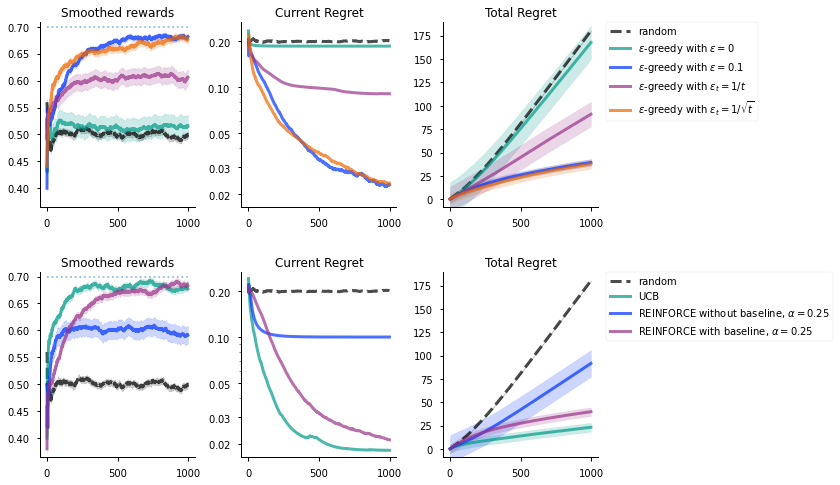

In [ ]:
experiment1.show()

## Experiment 2: reward = 0 on success, reward = -1 on failure.



In [ ]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


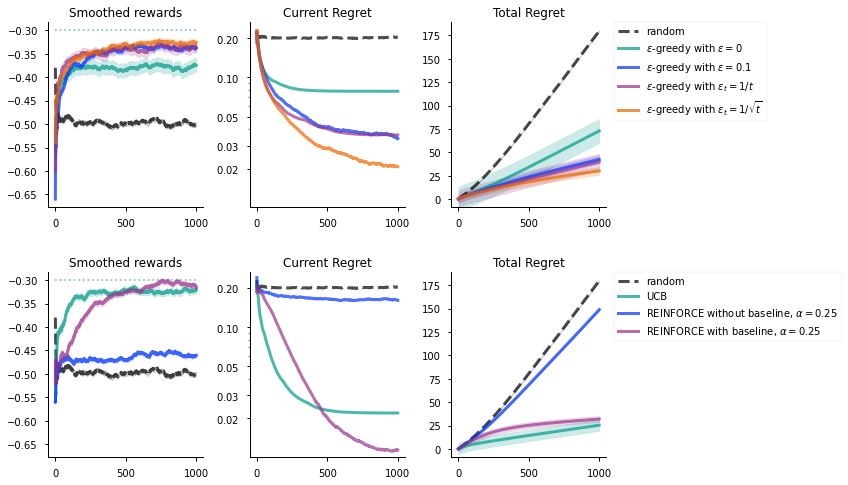

In [ ]:
experiment2.show()

## Experiment 3: Non-stationary bandit (I)
After 800 steps:
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [ ]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit (II)
After 800 steps:
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.




In [ ]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


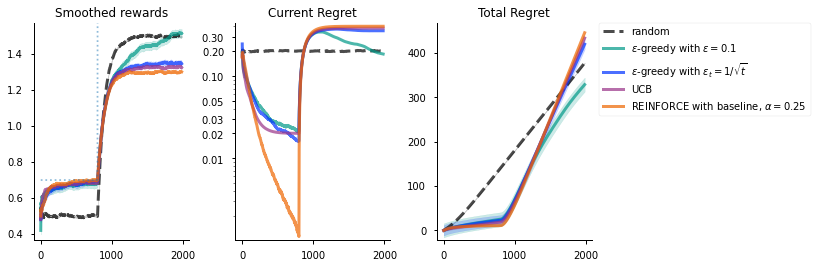

In [ ]:
experiment3.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


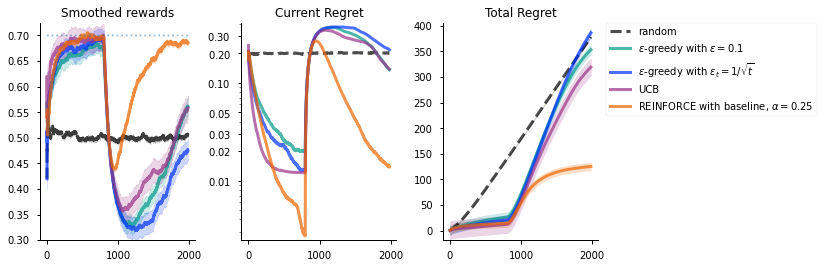

In [ ]:
experiment4.show()